In [18]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

In [ ]:
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
import torch


# Configuration paths
DB_PATH = r"F:\classification\ds_edu_videos.db"
EMBEDDING_PATH = r"F:\classification\embeddings_gte-Qwen2-7B-instruct\video_embeddings.npy"  # Modify according to the actual path
MAPPING_PATH = r"F:\classification\embeddings_gte-Qwen2-7B-instruct\video_id_mapping.txt"

# Load video_id mapping table
def load_video_mapping(mapping_path):
    with open(mapping_path, 'r') as f:
        # Format: each line corresponds to the row number of the npy file, content is video_id
        return {idx: line.strip() for idx, line in enumerate(f.readlines())}

# Get labeled data from the database
def get_labeled_data(db_path, training_table="gpt4o_training_labels", validation_test_table="manual_labels"):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute(f"SELECT video_id, gpt_label FROM {training_table}")
    training_data = {row[0]: row[1] for row in cursor.fetchall()}
    
    cursor.execute(f"SELECT video_id, relevance FROM {validation_test_table}")
    validation_test_data = {row[0]: row[1] for row in cursor.fetchall()}
    
    conn.close()
    return training_data, validation_test_data


# Main data processing flow
def prepare_data():
    # Load data
    idx_to_video = load_video_mapping(MAPPING_PATH)
    training_data, validation_test_data = get_labeled_data(DB_PATH)
    embeddings = np.load(EMBEDDING_PATH)

    # Align data
    X_train, y_train, train_indices = [], [], []
    X_val_test, y_val_test, val_test_indices = [], [], []
    
    for idx, video_id in idx_to_video.items():
        if video_id in training_data:
            try:
                X_train.append(embeddings[idx])
                y_train.append(training_data[video_id])
                train_indices.append(idx)
            except IndexError:
                print(f"Warning: Index {idx} out of bounds for embeddings")
        elif video_id in validation_test_data:
            try:
                X_val_test.append(embeddings[idx])
                y_val_test.append(validation_test_data[video_id])
                val_test_indices.append(idx)
            except IndexError:
                print(f"Warning: Index {idx} out of bounds for embeddings")
    
    return np.array(X_train), np.array(y_train), train_indices, np.array(X_val_test), np.array(y_val_test), val_test_indices, idx_to_video

def print_class_distribution(y, name="Dataset"):
    counts = Counter(y)
    print(f"\n{name} class distribution:")
    for cls, count in counts.items():
        print(f"  Class {cls}: {count} samples ({count/len(y)*100:.1f}%)")

# Apply SMOTE for balancing training data
def balance_training_data(X_train, y_train):
    smote = SMOTE(sampling_strategy='auto', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print_class_distribution(y_resampled, "Balanced Train")
    return X_resampled, y_resampled

# Data splitting function
def split_data(X_val_test, y_val_test, indices, test_size=0.5, random_state=42):
    X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
        X_val_test, y_val_test, indices,
        test_size=test_size,
        stratify=y_val_test,
        random_state=random_state
    )

    print_class_distribution(y_val, "Validation")
    print_class_distribution(y_test, "Test")
    
    return X_val, X_test, y_val, y_test, idx_val, idx_test

def save_metadata(idx_train, idx_val, idx_test, idx_to_video):
    # Save training set IDs
    with open("train_ids.txt", "w") as f:
        for idx in idx_train:
            f.write(f"{idx_to_video[idx]}\n")
    
    # Save validation set IDs
    with open("val_ids.txt", "w") as f:
        for idx in idx_val:
            f.write(f"{idx_to_video[idx]}\n")
    
    # Save test set IDs
    with open("test_ids.txt", "w") as f:
        for idx in idx_test:
            f.write(f"{idx_to_video[idx]}\n")

# Execute processing
if __name__ == "__main__":
    # Get data
    X_train, y_train, train_indices, X_val_test, y_val_test, val_test_indices, idx_to_video = prepare_data()

    # Balance training data
    X_train, y_train = balance_training_data(X_train, y_train)
    
    # Split dataset for validation and test
    X_val, X_test, y_val, y_test, idx_val, idx_test = split_data(X_val_test, y_val_test, val_test_indices)
     
    # Save features and labels
    np.save("F:\classification\embeddings_gte-Qwen2-7B-instruct\X_train.npy", X_train)
    np.save("F:\classification\embeddings_gte-Qwen2-7B-instruct\X_val.npy", X_val)
    np.save("F:\classification\embeddings_gte-Qwen2-7B-instruct\X_test.npy", X_test)
    np.save("F:\classification\embeddings_gte-Qwen2-7B-instruct\y_train.npy", y_train)
    np.save("F:\classification\embeddings_gte-Qwen2-7B-instruct\y_val.npy", y_val)
    np.save("F:\classification\embeddings_gte-Qwen2-7B-instruct\y_test.npy", y_test)
    
    # Save metadata
    save_metadata(train_indices, idx_val, idx_test, idx_to_video)
    
    # Print dataset information
    print(f"Total training samples: {len(X_train)}")
    print(f"Validation set: {len(X_val)} samples")
    print(f"Test set: {len(X_test)} samples")


Balanced Train class distribution:
  Class 1: 2486 samples (50.0%)
  Class 0: 2486 samples (50.0%)

Validation class distribution:
  Class 1: 243 samples (86.2%)
  Class 0: 39 samples (13.8%)

Test class distribution:
  Class 1: 242 samples (85.8%)
  Class 0: 40 samples (14.2%)
Total training samples: 4972
Validation set: 282 samples
Test set: 282 samples


## Prompt Performance


Test Metrics (class-wise):
              precision    recall  f1-score   support

           0      0.667     0.800     0.727        40
           1      0.966     0.934     0.950       242

    accuracy                          0.915       282
   macro avg      0.816     0.867     0.838       282
weighted avg      0.923     0.915     0.918       282

Accuracy: 0.915
Precision: 0.923
Recall: 0.915
F1-score: 0.918


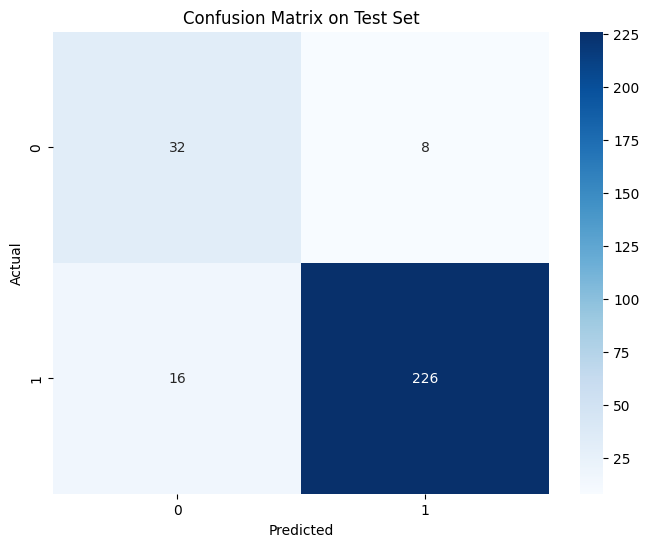

In [ ]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Database path
DB_PATH = r"F:\classification\ds_edu_videos.db"

# Load test set video_ids
def load_test_video_ids(file_path="test_ids.txt"):
    with open(file_path, "r") as f:
        return set(line.strip() for line in f.readlines())

# Get predictions and true labels from database
def get_gpt4o_results(db_path, test_video_ids):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    cursor.execute("""
        SELECT video_id, true_label, gpt_prediction
        FROM gpt4o_results_exclusion_modified
    """)
    
    data = cursor.fetchall()
    conn.close()
    
    # Filter only test set video_ids
    y_true, y_pred = [], []
    for video_id, true_label, gpt_prediction in data:
        if video_id in test_video_ids:
            y_true.append(true_label)
            y_pred.append(gpt_prediction)
    
    return np.array(y_true), np.array(y_pred)

# Compute class-wise metrics
def compute_class_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print("\nTest Metrics (class-wise):")
    print(classification_report(y_true, y_pred, zero_division=0, digits=3))
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1-score: {f1:.3f}")

# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix on Test Set")
    plt.show()

if __name__ == "__main__":
    # Load test video_ids
    test_video_ids = load_test_video_ids()
    
    # Get ground truth and GPT predictions
    y_true, y_pred = get_gpt4o_results(DB_PATH, test_video_ids)
    
    # Compute and print class-wise metrics
    compute_class_metrics(y_true, y_pred)
    
    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred)


## Model Performance ##

Cost-Aware Accuracy for model Logistic Regression: 0.812
Cost-Aware Accuracy for model Random Forest: 0.803
Cost-Aware Accuracy for model XGBoost: 0.889
Cost-Aware Accuracy for model SVM (Linear): 0.829
Cost-Aware Accuracy for model SVM (RBF): 0.805
Cost-Aware Accuracy for model MLP: 0.845

=== Model Performance Summary ===
| Model               |   Val AUC |   Val PR-AUC |   Test AUC |   Test PR-AUC |   Val F1-0 |   Val F1-1 |   Val F1-Macro |   Test F1-0 |   Test F1-1 |   Test F1-Macro |   Test F1-Micro |   Threshold |
|:--------------------|----------:|-------------:|-----------:|--------------:|-----------:|-----------:|---------------:|------------:|------------:|----------------:|----------------:|------------:|
| Logistic Regression |     0.924 |        0.987 |      0.924 |         0.985 |      0.667 |      0.939 |          0.803 |       0.588 |       0.89  |           0.739 |           0.826 |        0.82 |
| Random Forest       |     0.899 |        0.983 |      0.905 |        

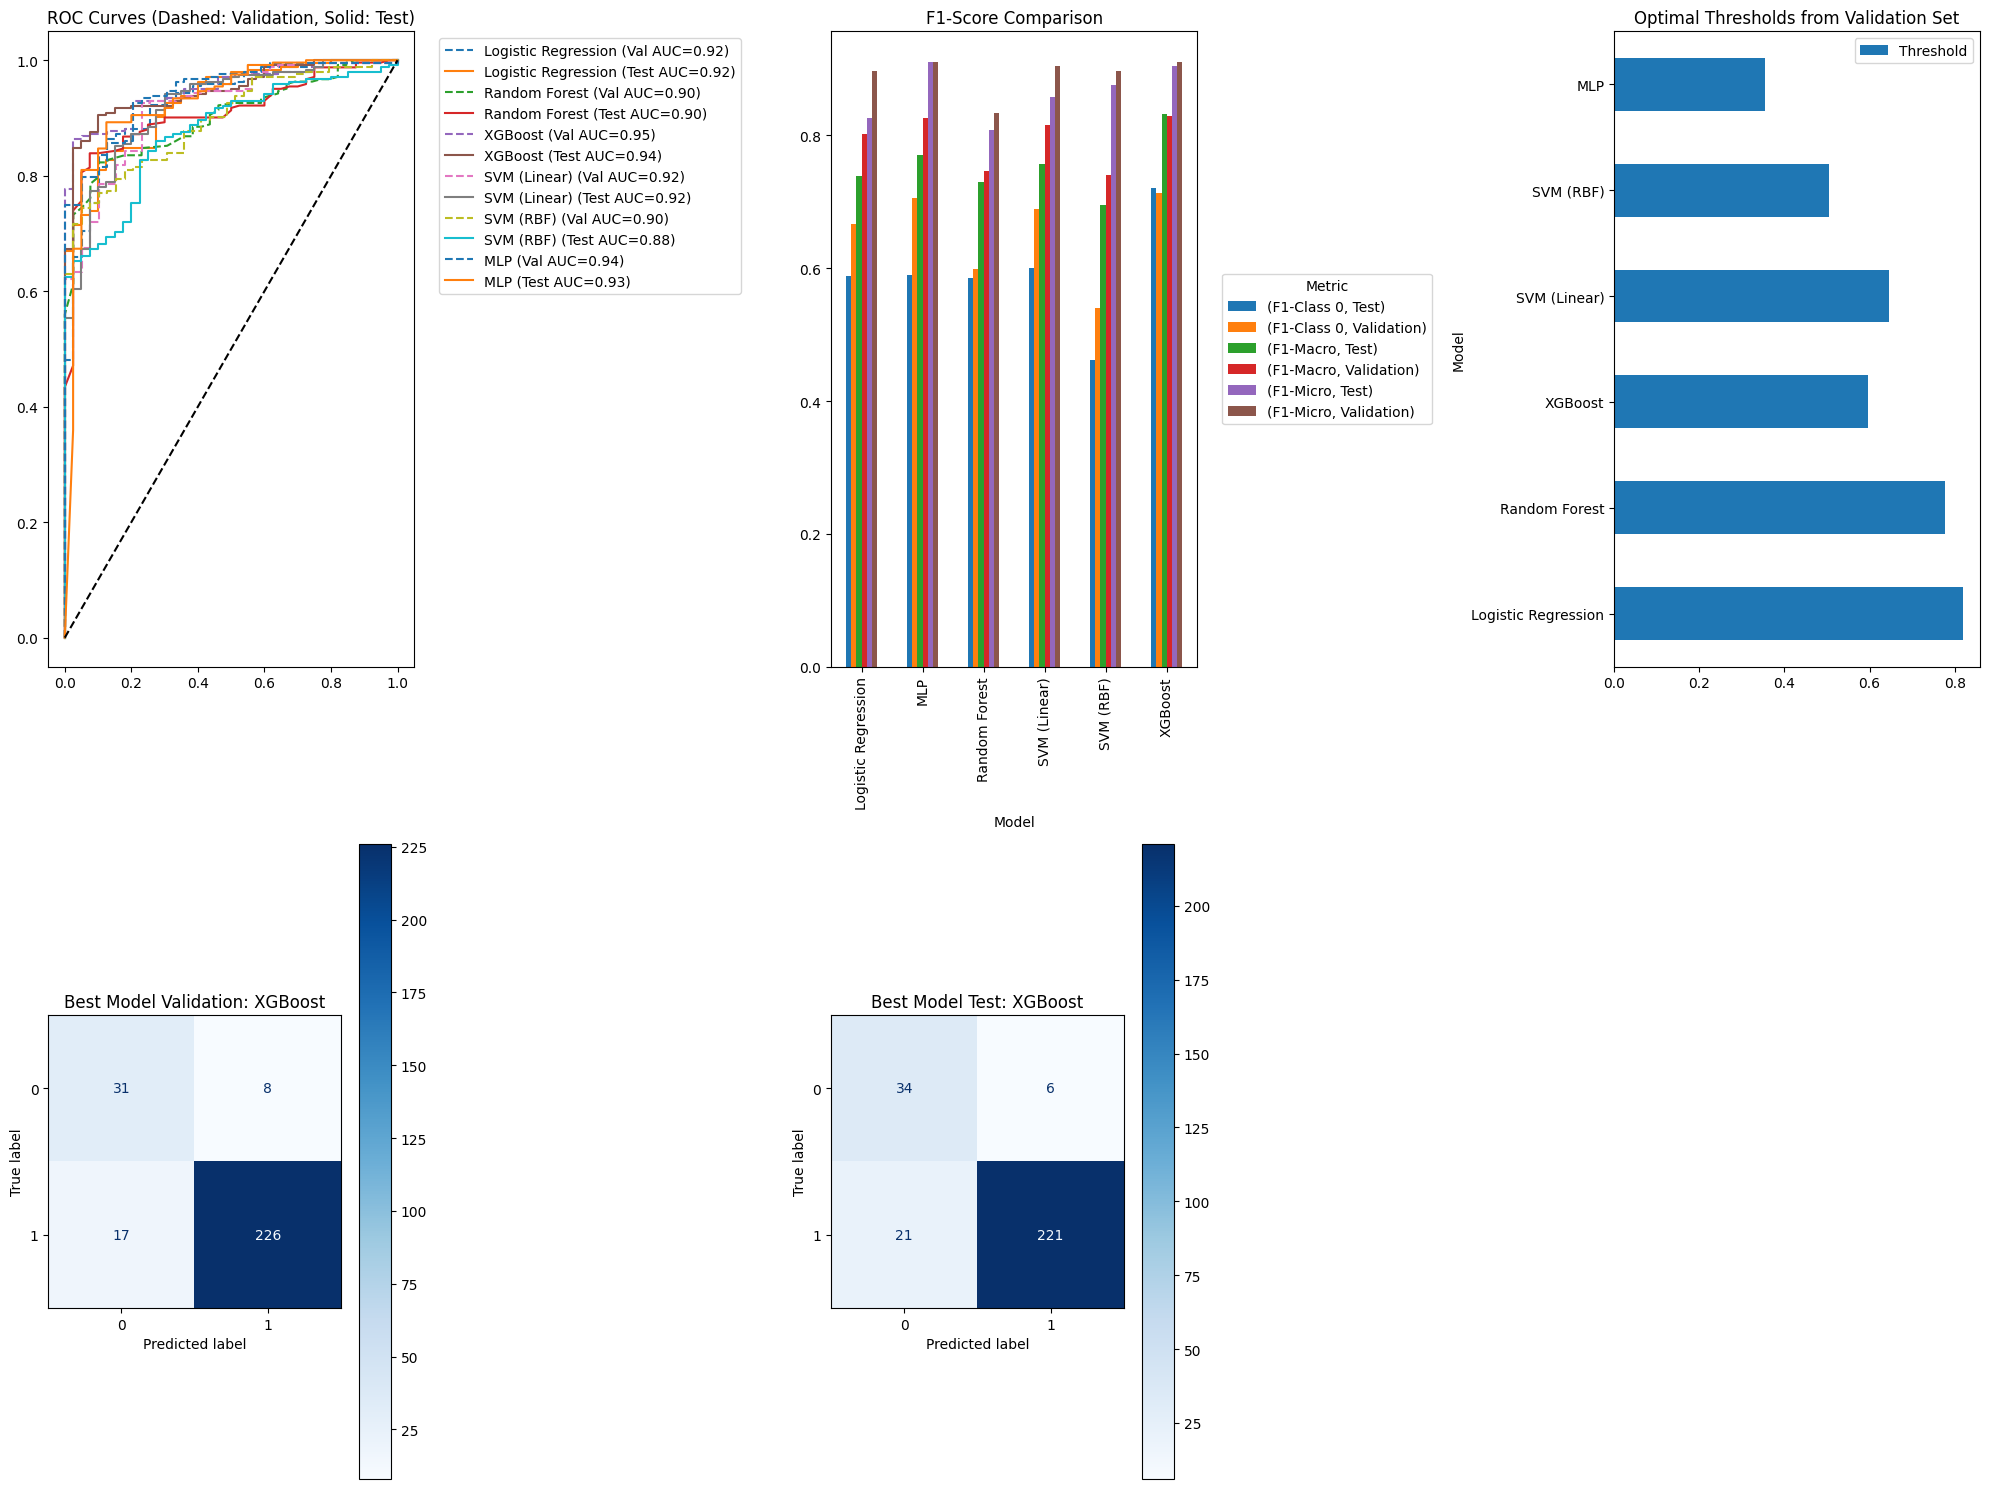

['F:/classification/embeddings_gte-Qwen2-7B-instruct/scaler.pkl']

In [3]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import time
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (classification_report, 
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             accuracy_score, 
                             roc_auc_score, 
                             f1_score,
                             precision_recall_curve,
                             average_precision_score,
                             roc_curve)
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.isotonic import IsotonicRegression
from itertools import combinations

def load_data():
    return (
        np.load("F:\classification\embeddings_gte-Qwen2-7B-instruct\X_train.npy"),
        np.load("F:\classification\embeddings_gte-Qwen2-7B-instruct\X_val.npy"),
        np.load("F:\classification\embeddings_gte-Qwen2-7B-instruct\X_test.npy"),
        np.load("F:\classification\embeddings_gte-Qwen2-7B-instruct\y_train.npy"),
        np.load("F:\classification\embeddings_gte-Qwen2-7B-instruct\y_val.npy"),
        np.load("F:\classification\embeddings_gte-Qwen2-7B-instruct\y_test.npy")
    )

def calculate_class_weights(y):
    class_counts = np.bincount(y)
    return {0: class_counts[1]/class_counts[0],  # 2x weight for class 0
            1: 1.0}

def cost_aware_threshold(y_true, probas, cost_matrix):
    thresholds = np.linspace(0, 1, 100) # 100 thresholds from 0 to 1
    costs = []
    for t in thresholds:
        pred = (probas >= t).astype(int)
        fn = np.sum((y_true == 1) & (pred == 0)) * cost_matrix["FN"]
        fp = np.sum((y_true == 0) & (pred == 1)) * cost_matrix["FP"]
        costs.append(fn + fp)
    return thresholds[np.argmin(costs)]

def train_and_evaluate_models(X_train, y_train, X_val, y_val, X_test, y_test):
    class_weights = calculate_class_weights(y_val)
    xgb_scale_pos = np.bincount(y_val)[1]/np.bincount(y_val)[0] # Scale pos_weight for XGBoost (same as class weights)
    
    models = {
        "Logistic Regression": LogisticRegression(class_weight=class_weights, max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(class_weight=class_weights, n_estimators=100, random_state=42, n_jobs=-1),
        "XGBoost": XGBClassifier(
            scale_pos_weight=xgb_scale_pos,  # Increase weight for class 0
            n_estimators=2000,
            max_depth=5,  # Limit tree depth
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            early_stopping_rounds=50,
            eval_metric='aucpr',
            random_state=42,
            n_jobs=-1
        ),
        "SVM (Linear)": CalibratedClassifierCV(SVC(kernel='linear', class_weight=class_weights, probability=False), cv=3),
        "SVM (RBF)": CalibratedClassifierCV(SVC(kernel='rbf', class_weight=class_weights, probability=False), cv=3),
        "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), early_stopping=True, validation_fraction=0.1, random_state=42)
    }
    
    results = {}
    best_model = None
    best_score = 0
    
    for name, model in models.items():
        try:
            start_time = time.time()
            # Train model
            if isinstance(model, XGBClassifier):
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],  # Pass validation set here
                    verbose=0  # Control log output
                )
            else:
                model.fit(X_train, y_train)
            train_time = time.time() - start_time
            
            # Validation evaluation
            cost_matrix = {"FN": 1, "FP": 2}  # Cost of false negative (missed class 0) is 5x
            val_proba = model.predict_proba(X_val)[:, 1]
            optimal_threshold = cost_aware_threshold(y_val, val_proba, cost_matrix)
            val_pred = (val_proba >= optimal_threshold).astype(int)
            
            # Test evaluation
            if not isinstance(model, CalibratedClassifierCV):  # only calibrate non-probabilistic models
                calibrator = IsotonicRegression(out_of_bounds='clip')
                calibrator.fit(model.predict_proba(X_val)[:, 1], y_val)
                test_proba = calibrator.transform(model.predict_proba(X_test)[:, 1])
            else:
                test_proba = model.predict_proba(X_test)[:, 1]
            test_pred = (test_proba >= optimal_threshold).astype(int)

            cost_aware_acc = cost_aware_accuracy(y_test, test_pred, cost_matrix)
            print(f"Cost-Aware Accuracy for model {name}: {cost_aware_acc:.3f}")
            
            # Store metrics
            results[name] = {
                "model": model,
                "threshold": optimal_threshold,
                "validation": {
                    "roc_auc": roc_auc_score(y_val, val_proba),
                    "pr_auc": average_precision_score(y_val, val_proba),
                    "f1_class_0": f1_score(y_val, val_pred, pos_label=0),
                    "f1_class_1": f1_score(y_val, val_pred, pos_label=1),
                    "f1_macro": f1_score(y_val, val_pred, average='macro'),
                    "f1_micro": f1_score(y_val, val_pred, average='micro'),
                    "report": format_classification_report(y_val, val_pred),  # Add parameter
                },
                "test": {
                    "roc_auc": roc_auc_score(y_test, test_proba),
                    "pr_auc": average_precision_score(y_test, test_proba),
                    "f1_class_0": f1_score(y_test, test_pred, pos_label=0),
                    "f1_class_1": f1_score(y_test, test_pred, pos_label=1),
                    "f1_macro": f1_score(y_test, test_pred, average='macro'),
                    "f1_micro": f1_score(y_test, test_pred, average='micro'),
                    "report_class0": classification_report(
                        y_test, test_pred,
                        zero_division=0,  # Add parameter
                        target_names=["Class 0", "Class 1"],
                        output_dict=True
                    )["Class 0"],
                    "report": format_classification_report(y_test, test_pred),  # Add parameter
                },
                "train_time": train_time
            }
            
            if results[name]["validation"]["roc_auc"] > best_score:
                best_score = results[name]["validation"]["roc_auc"]
                best_model = model
                
        except Exception as e:
            print(f"Training {name} failed: {str(e)}")
            results[name] = None
            
    return results, best_model

def cost_aware_accuracy(y_true, y_pred, cost_matrix):
    FN = np.sum((y_true == 1) & (y_pred == 0)) * cost_matrix["FN"]
    FP = np.sum((y_true == 0) & (y_pred == 1)) * cost_matrix["FP"]
    TN = np.sum((y_true == 0) & (y_pred == 0))
    TP = np.sum((y_true == 1) & (y_pred == 1))
    
    total_cost = FN + FP
    total_instances = FN + FP + TN + TP  # Total samples
    
    return 1 - (total_cost / total_instances)  # Cost-Aware Accuracy


def visualize_comparison(results):
    fig = plt.figure(figsize=(20, 15))
    
    # ROC Curves Comparison
    ax1 = plt.subplot(231)
    for name, res in results.items():
        if not res: continue
        # Validation ROC
        val_proba = res["model"].predict_proba(X_val_scaled)[:, 1]
        fpr_val, tpr_val, _ = roc_curve(y_val, val_proba)
        auc_val = res["validation"]["roc_auc"]
        ax1.plot(fpr_val, tpr_val, linestyle='--', 
                label=f"{name} (Val AUC={auc_val:.2f})")
        
        # Test ROC
        test_proba = res["model"].predict_proba(X_test_scaled)[:, 1]
        fpr_test, tpr_test, _ = roc_curve(y_test, test_proba)
        auc_test = res["test"]["roc_auc"]
        ax1.plot(fpr_test, tpr_test, linestyle='-',
                label=f"{name} (Test AUC={auc_test:.2f})")
    ax1.plot([0,1], [0,1], 'k--')
    ax1.set_title("ROC Curves (Dashed: Validation, Solid: Test)")
    ax1.legend(bbox_to_anchor=(1.05,1), loc='upper left')

    # F1-Score Comparison
    ax2 = plt.subplot(232)
    metric_data = []
    for name, res in results.items():
        if not res: continue
        metric_data.append({
            "Model": name,
            "Dataset": "Validation",
            "F1-Class 0": res["validation"]["f1_class_0"],
            "F1-Macro": res["validation"]["f1_macro"],
            "F1-Micro": res["validation"]["f1_micro"]
        })
        metric_data.append({
            "Model": name,
            "Dataset": "Test",
            "F1-Class 0": res["test"]["f1_class_0"],
            "F1-Macro": res["test"]["f1_macro"],
            "F1-Micro": res["test"]["f1_micro"]
        })
    pd.DataFrame(metric_data).set_index(["Model", "Dataset"]).unstack().plot(kind='bar', ax=ax2)
    ax2.set_title("F1-Score Comparison")
    ax2.legend(title='Metric', bbox_to_anchor=(1.05,0.5), loc='center left')

    # Threshold Analysis
    ax3 = plt.subplot(233)
    thresholds = [(name, res["threshold"]) for name, res in results.items() if res]
    pd.DataFrame(thresholds, columns=["Model", "Threshold"]).set_index("Model").plot(kind='barh', ax=ax3)
    ax3.set_title("Optimal Thresholds from Validation Set")

    # Confusion Matrices
    best_model_name = max(results, key=lambda n: results[n]["validation"]["roc_auc"] if results[n] else 0)
    ax4 = plt.subplot(234)
    ConfusionMatrixDisplay.from_predictions(y_val, 
        (results[best_model_name]["model"].predict_proba(X_val_scaled)[:, 1] >= results[best_model_name]["threshold"]).astype(int),
        ax=ax4, cmap='Blues')
    ax4.set_title(f"Best Model Validation: {best_model_name}")
    
    ax5 = plt.subplot(235)
    ConfusionMatrixDisplay.from_predictions(y_test, 
        (results[best_model_name]["model"].predict_proba(X_test_scaled)[:, 1] >= results[best_model_name]["threshold"]).astype(int),
        ax=ax5, cmap='Blues')
    ax5.set_title(f"Best Model Test: {best_model_name}")

    plt.tight_layout()
    plt.show()

def create_interaction_features(X):
    interaction = X[:, 0] * X[:, 1]  # Assume the first two columns are important features
    return np.c_[X, interaction]

def format_classification_report(y_true, y_pred):
    report_dict = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    formatted_report = ""
    for label, metrics in report_dict.items():
        if isinstance(metrics, dict):  # Ignore 'accuracy', 'macro avg', 'weighted avg'
            formatted_report += f"{label}:\n"
            formatted_report += f"  Precision: {metrics['precision']:.3f}\n"
            formatted_report += f"  Recall: {metrics['recall']:.3f}\n"
            formatted_report += f"  F1-score: {metrics['f1-score']:.3f}\n"
            formatted_report += f"  Support: {metrics['support']}\n"
    return formatted_report

# Main flow
X_train, X_val, X_test, y_train, y_val, y_test = load_data()

X_train = create_interaction_features(X_train)
X_val = create_interaction_features(X_val)
X_test = create_interaction_features(X_test)

# Feature scaling
scaler = StandardScaler()
global X_val_scaled, X_test_scaled  # For visualization
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test) 

# Train and evaluate models
results, best_model = train_and_evaluate_models(X_train_scaled, y_train, 
                                                X_val_scaled, y_val,
                                                X_test_scaled, y_test)

# Print performance table
print("\n=== Model Performance Summary ===")
summary = []
for name, res in results.items():
    if not res: continue
    summary.append({
        "Model": name,
        "Val AUC": f"{res['validation']['roc_auc']:.3f}",
        "Val PR-AUC": f"{res['validation']['pr_auc']:.3f}",
        "Test AUC": f"{res['test']['roc_auc']:.3f}",
        "Test PR-AUC": f"{res['test']['pr_auc']:.3f}",
        "Val F1-0": f"{res['validation']['f1_class_0']:.3f}",
        "Val F1-1": f"{res['validation']['f1_class_1']:.3f}",
        "Val F1-Macro": f"{res['validation']['f1_macro']:.3f}",
        "Test F1-0": f"{res['test']['f1_class_0']:.3f}",
        "Test F1-1": f"{res['test']['f1_class_1']:.3f}",
        "Test F1-Macro": f"{res['test']['f1_macro']:.3f}",
        "Test F1-Micro": f"{res['test']['f1_micro']:.3f}",
        "Threshold": f"{res['threshold']:.2f}"
    })
print(pd.DataFrame(summary).to_markdown(index=False))

# Detailed reports
print("\n=== Best Model Performance ===")
best_name = max(results, key=lambda n: results[n]["validation"]["roc_auc"] if results[n] else 0)
print(f"\n** Validation Report ({best_name}) **")
print(results[best_name]["validation"]["report"])
print(f"\n** Test Report ({best_name}) **")
print(results[best_name]["test"]["report"])

# Visualizations
visualize_comparison(results)

# Save results
joblib.dump(results, "F:/classification/embeddings_gte-Qwen2-7B-instruct/final_model_comparison.pkl")

# Save best model
joblib.dump(best_model, "F:/classification/embeddings_gte-Qwen2-7B-instruct/best_model.pkl")

# Save scaler
joblib.dump(scaler, "F:/classification/embeddings_gte-Qwen2-7B-instruct/scaler.pkl")



In [25]:
for name, res in results.items():
    if not res: continue
    print(f"\n** Test Report ({name}) **")
    print(res["test"]["report"])


** Test Report (Logistic Regression) **
0:
  Precision: 0.443
  Recall: 0.875
  F1-score: 0.588
  Support: 40.0
1:
  Precision: 0.975
  Recall: 0.818
  F1-score: 0.890
  Support: 242.0
macro avg:
  Precision: 0.709
  Recall: 0.847
  F1-score: 0.739
  Support: 282.0
weighted avg:
  Precision: 0.900
  Recall: 0.826
  F1-score: 0.847
  Support: 282.0


** Test Report (Random Forest) **
0:
  Precision: 0.422
  Recall: 0.950
  F1-score: 0.585
  Support: 40.0
1:
  Precision: 0.990
  Recall: 0.785
  F1-score: 0.876
  Support: 242.0
macro avg:
  Precision: 0.706
  Recall: 0.868
  F1-score: 0.730
  Support: 282.0
weighted avg:
  Precision: 0.909
  Recall: 0.809
  F1-score: 0.834
  Support: 282.0


** Test Report (XGBoost) **
0:
  Precision: 0.614
  Recall: 0.875
  F1-score: 0.722
  Support: 40.0
1:
  Precision: 0.978
  Recall: 0.909
  F1-score: 0.942
  Support: 242.0
macro avg:
  Precision: 0.796
  Recall: 0.892
  F1-score: 0.832
  Support: 282.0
weighted avg:
  Precision: 0.926
  Recall: 0.90

In [ ]:
import numpy as np
import joblib
import pandas as pd

# Load model and scaler
best_model = joblib.load("F:/classification/embeddings_gte-Qwen2-7B-instruct/best_model.pkl")
scaler = joblib.load("F:/classification/embeddings_gte-Qwen2-7B-instruct/scaler.pkl")

# Load all video ID mappings
idx_to_video = load_video_mapping(MAPPING_PATH)

# Load used video IDs (training, validation, test sets)
used_video_ids = set()

# Load all video embeddings
embeddings = np.load(EMBEDDING_PATH)

# Filter out unlabeled data
unlabeled_indices = [idx for idx, vid in idx_to_video.items() if vid not in used_video_ids]
X_unlabeled = np.array([embeddings[idx] for idx in unlabeled_indices])
video_ids_unlabeled = [idx_to_video[idx] for idx in unlabeled_indices]

# Perform the same interaction feature engineering
def create_interaction_features(X):
    interaction = X[:, 0] * X[:, 1]  # interaction term of the first two features
    return np.c_[X, interaction]

X_unlabeled = create_interaction_features(X_unlabeled)

# Normalize
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# Make predictions
probas = best_model.predict_proba(X_unlabeled_scaled)[:, 1]  # Get the probability of class 1 (positive class)
optimal_threshold = results["XGBoost"]["threshold"]  # Get the optimal threshold from training results
predicted_labels = (probas >= optimal_threshold).astype(int)

# Generate results DataFrame
df_results = pd.DataFrame({
    "video_id": video_ids_unlabeled,
    "predicted_label": predicted_labels,
    "confidence": probas
})

# Save to CSV
output_path = "F:/classification/embeddings_gte-Qwen2-7B-instruct/unlabeled_predictions.csv"
df_results.to_csv(output_path, index=False)

print(f"Predictions for unlabeled data have been saved to: {output_path}")


Predictions for unlabeled data have been saved to: F:/classification/embeddings_gte-Qwen2-7B-instruct/unlabeled_predictions.csv


In [ ]:
import pandas as pd
import sqlite3

# Read prediction results CSV
csv_path = r"F:\classification\embeddings_gte-Qwen2-7B-instruct\unlabeled_predictions.csv"
df_results = pd.read_csv(csv_path)

# Connect to database
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Update each record
for _, row in df_results.iterrows():
    video_id = row["video_id"]
    predicted_label = int(row["predicted_label"])
    confidence = float(row["confidence"])

    cursor.execute("""
        UPDATE videos 
        SET predicted_label = ?, confidence = ?
        WHERE video_id = ?
    """, (predicted_label, confidence, video_id))

# Commit changes and close connection
conn.commit()
conn.close()

print("Database updated with predicted labels and confidence scores.")


Database updated with predicted labels and confidence scores.


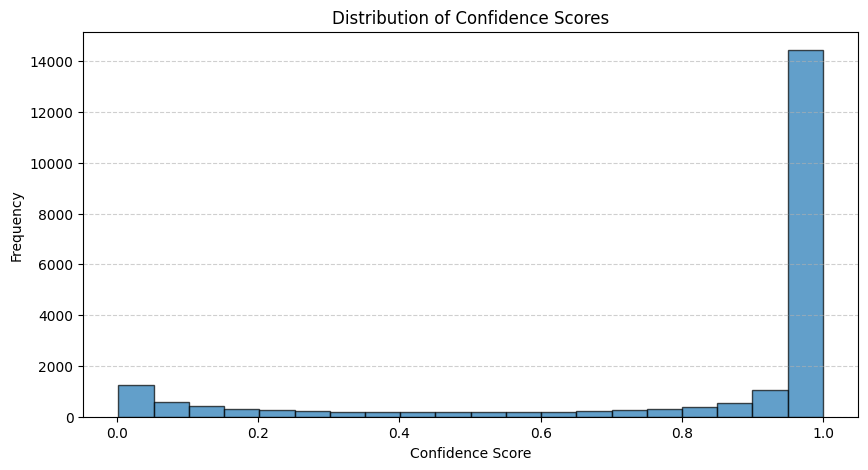

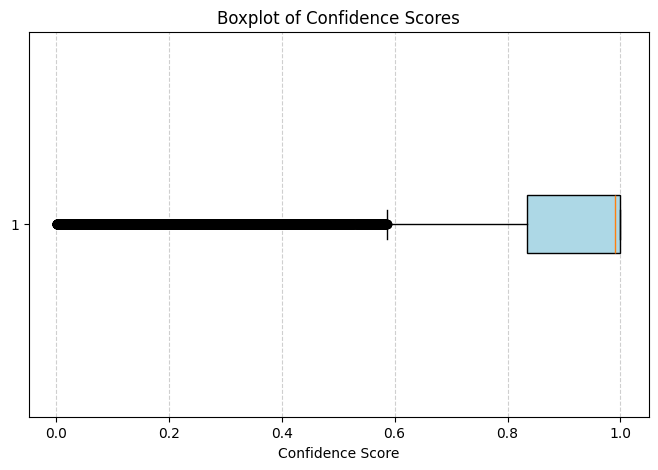

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "F:/classification/embeddings_gte-Qwen2-7B-instruct/unlabeled_predictions.csv"
df = pd.read_csv(csv_path)

# histogram
plt.figure(figsize=(10, 5))
plt.hist(df["confidence"], bins=20, edgecolor="black", alpha=0.7)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence Scores")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(df["confidence"], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
plt.xlabel("Confidence Score")
plt.title("Boxplot of Confidence Scores")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()


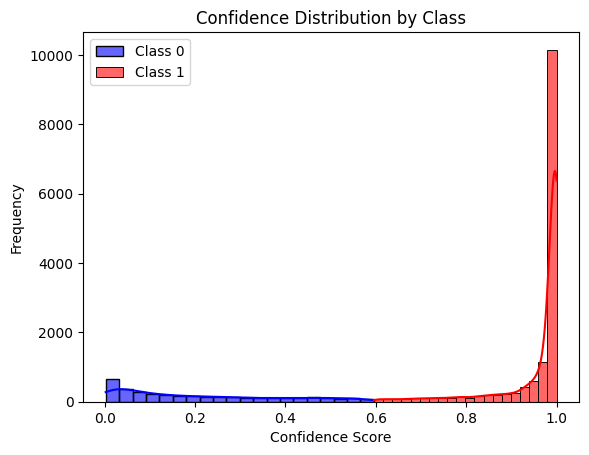

In [ ]:
import seaborn as sns

sns.histplot(df[df["predicted_label"] == 0]["confidence"], bins=20, kde=True, label="Class 0", color="blue", alpha=0.6)
sns.histplot(df[df["predicted_label"] == 1]["confidence"], bins=20, kde=True, label="Class 1", color="red", alpha=0.6)
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Confidence Distribution by Class")
plt.legend()
plt.show()
